<a href="https://colab.research.google.com/github/aishwaryasnair0-create/OSCCTool/blob/Other-Studies/cs_predictive_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
#Step 0: Identify Version and Platform Used
import sys
import platform

import numpy as np
import pandas as pd
import matplotlib
import sklearn
import statsmodels

print("Python version:", sys.version)
print("Platform:", platform.platform())
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("matplotlib:", matplotlib.__version__)
print("scikit-learn:", sklearn.__version__)
print("statsmodels:", statsmodels.__version__)

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
numpy: 2.0.2
pandas: 2.2.2
matplotlib: 3.10.0
scikit-learn: 1.6.1
statsmodels: 0.14.5


In [8]:
# Step 1: Load the Excel file

import pandas as pd

excel_path = "srikant.xlsx"  # make sure the filename matches exactly

# Read the workbook and show sheet names
xls = pd.ExcelFile(excel_path)
print("Sheets found:", xls.sheet_names)

# For this project we will use the second sheet, which holds the structured data
df_raw = pd.read_excel(xls, sheet_name="Sheet1 (2)")

print("Raw shape (rows, columns):", df_raw.shape)

# Look at the first 5 rows to understand what they look like
df_raw.head()


Sheets found: ['Sheet1', 'Sheet1 (2)']
Raw shape (rows, columns): (256, 30)


,Unnamed: 0,NAME,age,sex,Canalis,left,RIGHT,anatomical position,Unnamed: 8,TOOTH LEFT,...,Unnamed: 20,less than 1mm,Unnamed: 22,cs to alveolar crest,Unnamed: 24,cs to buccal cortical plate,Unnamed: 26,csto floor of nasal cavity,Unnamed: 28,Unnamed: 29
0,NaN,NaN,NaN,NaN,PR/AB,left,right,left,right,NaN,...,right,left,right,left,right,left right,right,left,right,NaN
1,1.0,AKSHATH,34.0,M,2,1,1,4,7,1,...,NaN,NaN,NaN,5.83,2.61,7.6,7.77,16.47,19.84,NaN
2,2.0,CHAITRA,27.0,F,1,0,1,0,2,0,...,NaN,NaN,NaN,0,4.39,0,4.05,0,14.12,ACCESSORY CANAL
3,3.0,CHANDRIKA,59.0,F,0,0,0,0,0,0,...,NaN,NaN,NaN,0,0,0,0,0,0,NaN
4,4.0,DEEPAK,32.0,M,2,1,1,2,5,2,...,NaN,NaN,NaN,10.53,10.91,8.49,6.44,10.22,15.82,NaN


In [10]:
import pandas as pd

# Step 1: Load Excel (adjust path if in Colab)
file_path = '/content/srikant.xlsx'  # Upload via Colab interface
df_raw = pd.read_excel(file_path, header=0, skiprows=[1])

# Step 2: Select relevant columns and rename
df = df_raw[['NAME', 'age', 'sex', 'Canalis', 'location', 'Unnamed: 6', 'anatomical position']].copy()
df.columns = ['name', 'age', 'sex', 'canalis_total', 'left_cs', 'right_cs', 'canal_position_code']

# Step 3: Clean and convert types
df = df[df['name'].notna()]
df[['age', 'canalis_total', 'left_cs', 'right_cs', 'canal_position_code']] = df[[
    'age', 'canalis_total', 'left_cs', 'right_cs', 'canal_position_code'
]].apply(pd.to_numeric, errors='coerce')

# Step 4: Melt from wide to long format
df_long = pd.melt(
    df,
    id_vars=['name', 'age', 'sex', 'canalis_total', 'canal_position_code'],
    value_vars=['left_cs', 'right_cs'],
    var_name='side',
    value_name='cs_present'
)
df_long['side'] = df_long['side'].str.replace('_cs', '').str.upper()

# Step 5: Map anatomical position
anatomical_map = {
    1: 'PAL CI',
    2: 'PAL LI',
    3: 'PAL CAN',
    4: 'DIS PAL CI',
    5: 'DIS PAL LI',
    6: 'DIS PAL CAN',
    7: 'MES PAL CI',
    8: 'MES PAL LI',
    9: 'MES PAL CAN',
    0: 'ABSENT'
}
df_long['canal_position_desc'] = df_long['canal_position_code'].map(anatomical_map)

# Step 6: Save to file
df_long.to_excel('/content/cleaned_canal_data.xlsx', index=False)
print("✅ Done. File saved as 'cleaned_canal_data.xlsx'")


✅ Done. File saved as 'cleaned_canal_data.xlsx'


In [11]:
# Step 3: Load the cleaned side-level dataset

import pandas as pd

clean_path = "/content/cleaned_canal_data.xlsx"  # adjust if needed
df_side = pd.read_excel(clean_path)

print("Shape of df_side (rows, columns):", df_side.shape)
df_side.head()


Shape of df_side (rows, columns): (492, 8)


,name,age,sex,canalis_total,canal_position_code,side,cs_present,canal_position_desc
0,AKSHATH,34.0,M,2.0,4.0,LEFT,1.0,DIS PAL CI
1,CHAITRA,27.0,F,1.0,0.0,LEFT,0.0,ABSENT
2,CHANDRIKA,59.0,F,0.0,0.0,LEFT,0.0,ABSENT
3,DEEPAK,32.0,M,2.0,2.0,LEFT,1.0,PAL LI
4,FLORA PINTO,60.0,F,2.0,4.0,LEFT,1.0,DIS PAL CI


In [15]:
import pandas as pd
import numpy as np

# 1. Load the original Excel file (no skiprows)
file_path = '/content/srikant.xlsx'  # adjust if your path is different
raw = pd.read_excel(file_path, header=0)

# 2. Keep only true patient rows
#    - Drop the top label row (NAME is NaN)
#    - Drop the 'OVERR' row (age is NaN)
df = raw.copy()
df = df[df['NAME'].notna()]
df = df[df['age'].notna()]   # this should leave 245 patients

print("Patients after cleaning:", df.shape[0])  # should be 245

# 3. Fix the one obvious data entry error:
#    Case where Canalis = 0 but right side column has '9' instead of going into the position column
left_present  = pd.to_numeric(df['location'],    errors='coerce')
right_present = pd.to_numeric(df['Unnamed: 6'], errors='coerce')
canalis_total = pd.to_numeric(df['Canalis'],     errors='coerce')

# Rows where total = 0 but right_present > 0 (this is LILLY MONTEIRO)
mask_mismatch = (canalis_total == 0) & (right_present > 0)

# Move that value into the right-side position column and set right_present to 0
df.loc[mask_mismatch, 'Unnamed: 10'] = df.loc[mask_mismatch, 'Unnamed: 6']
df.loc[mask_mismatch, 'Unnamed: 6'] = 0

# 4. Build LEFT and RIGHT side dataframes with proper position codes

# LEFT side: location + anatomical position
left = df[['NAME', 'age', 'sex', 'Canalis', 'location', 'anatomical position']].copy()
left.columns = ['name', 'age', 'sex', 'canalis_total', 'cs_present', 'position_code']
left['side'] = 'LEFT'

# RIGHT side: Unnamed: 6 (presence) + Unnamed: 10 (position)
right = df[['NAME', 'age', 'sex', 'Canalis', 'Unnamed: 6', 'Unnamed: 10']].copy()
right.columns = ['name', 'age', 'sex', 'canalis_total', 'cs_present', 'position_code']
right['side'] = 'RIGHT'

# 5. Convert numeric columns
for col in ['age', 'canalis_total', 'cs_present', 'position_code']:
    left[col] = pd.to_numeric(left[col], errors='coerce')
    right[col] = pd.to_numeric(right[col], errors='coerce')

# 6. For sides with NO canal (cs_present == 0), force position_code = 0
left.loc[left['cs_present'] == 0, 'position_code'] = 0
right.loc[right['cs_present'] == 0, 'position_code'] = 0

# 7. Combine LEFT and RIGHT into one long table
df_long = pd.concat([left, right], ignore_index=True)

print("Rows (patient-sides) after combine:", df_long.shape[0])  # should be 490

# 8. Create a text label for anatomical position
#    1–9 = specific locations; 0 = ABSENT if no canal, or UNKNOWN if canal present but no code

anatomical_map_no_zero = {
    1: 'PAL CI',
    2: 'PAL LI',
    3: 'PAL CAN',
    4: 'DIS PAL CI',
    5: 'DIS PAL LI',
    6: 'DIS PAL CAN',
    7: 'MES PAL CI',
    8: 'MES PAL LI',
    9: 'MES PAL CAN'
}

df_long['position_desc'] = np.where(
    df_long['cs_present'] == 0,
    'ABSENT',
    df_long['position_code'].map(anatomical_map_no_zero).fillna('UNKNOWN')
)

# 9. Final check: no missing values in key fields
print("\nMissing values per column:")
print(df_long.isna().sum())

# 10. Save the fully cleaned, side-level dataset
output_path = '/content/cleaned_canal_data_v2.xlsx'
df_long.to_excel(output_path, index=False)
print(f"\n✅ Done. File saved as '{output_path}'")


Patients after cleaning: 245
Rows (patient-sides) after combine: 490

Missing values per column:
name             0
age              0
sex              0
canalis_total    0
cs_present       0
position_code    0
side             0
position_desc    0
dtype: int64

✅ Done. File saved as '/content/cleaned_canal_data_v2.xlsx'


In [16]:
import pandas as pd
import numpy as np

# 1. Load the fully cleaned side-level data you created earlier
file_path = "/content/cleaned_canal_data_v2.xlsx"  # change if your path is different
df = pd.read_excel(file_path)

print("Original shape (rows, columns):", df.shape)
print("Original columns:", df.columns.tolist())

# 2. Standardize column names (lowercase, underscores)
df.columns = (
    df.columns
      .astype(str)
      .str.strip()
      .str.lower()
      .str.replace(r"\s+", "_", regex=True)
)

print("\nStandardized columns:", df.columns.tolist())

# 3. Convert numeric columns
for col in ["age", "canalis_total", "cs_present", "position_code"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# 4. Clean text columns
if "sex" in df.columns:
    df["sex"] = df["sex"].astype(str).str.strip().str.upper()

if "side" in df.columns:
    df["side"] = df["side"].astype(str).str.strip().str.upper()

# 5. Create modelling variables

# Binary sex: 1 = male, 0 = female
df["sex_male"] = np.where(df["sex"] == "M", 1,
                          np.where(df["sex"] == "F", 0, np.nan))

# Outcome: canal present on that side (0/1)
df["cs_present_bin"] = np.where(df["cs_present"] >= 1, 1,
                                np.where(df["cs_present"] == 0, 0, np.nan))

# Side indicator: 1 = RIGHT, 0 = LEFT
df["side_right"] = np.where(df["side"] == "RIGHT", 1,
                            np.where(df["side"] == "LEFT", 0, np.nan))

# 6. Check missing values in key variables
key_vars = ["age", "sex_male", "side_right", "cs_present_bin"]
print("\nMissing values in key variables BEFORE dropping:")
print(df[key_vars].isna().sum())

# 7. Drop rows with missing values in these key variables
before = df.shape[0]
df_model = df.dropna(subset=key_vars).copy()
after = df_model.shape[0]

print(f"\nRows before dropping missing in key vars: {before}")
print(f"Rows after  dropping missing in key vars: {after}")
print(f"Rows dropped: {before - after}")

# 8. Add simple IDs for reproducibility
df_model = df_model.reset_index(drop=True)
df_model["side_id"] = np.arange(1, len(df_model) + 1)

print("\nPreview of modelling dataset (df_model):")
print(df_model.head())
print("\nFinal modelling dataset shape:", df_model.shape)
print("\ncs_present_bin value counts (0 = no canal, 1 = canal present):")
print(df_model["cs_present_bin"].value_counts())


Original shape (rows, columns): (490, 8)
Original columns: ['name', 'age', 'sex', 'canalis_total', 'cs_present', 'position_code', 'side', 'position_desc']

Standardized columns: ['name', 'age', 'sex', 'canalis_total', 'cs_present', 'position_code', 'side', 'position_desc']

Missing values in key variables BEFORE dropping:
age               0
sex_male          0
side_right        0
cs_present_bin    0
dtype: int64

Rows before dropping missing in key vars: 490
Rows after  dropping missing in key vars: 490
Rows dropped: 0

Preview of modelling dataset (df_model):
          name  age sex  canalis_total  cs_present  position_code  side  \
0      AKSHATH   34   M              2           1              4  LEFT   
1      CHAITRA   27   F              1           0              0  LEFT   
2    CHANDRIKA   59   F              0           0              0  LEFT   
3       DEEPAK   32   M              2           1              2  LEFT   
4  FLORA PINTO   60   F              2           1       

In [18]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# 1. Define predictors (X) and outcome (y)
X = df_model[['age', 'sex_male', 'side_right']].copy()
X = sm.add_constant(X)  # adds intercept
y = df_model['cs_present_bin']

# 2. Fit a binomial GLM (logistic regression) with cluster-robust SEs by patient
glm_model = sm.GLM(y, X, family=sm.families.Binomial())
glm_result = glm_model.fit(
    cov_type='cluster',
    cov_kwds={'groups': df_model['name']}  # cluster = patient name
)

print("\n=== Logistic regression with cluster-robust SEs (by patient) ===")
print(glm_result.summary())

# 3. Create odds-ratio table
params = glm_result.params
conf = glm_result.conf_int()
pvals = glm_result.pvalues

or_table = pd.DataFrame({
    'OR': np.exp(params),
    'CI_low': np.exp(conf[0]),
    'CI_high': np.exp(conf[1]),
    'p_value': pvals
})

print("\n=== Odds ratios with 95% CI (cluster-robust SEs) ===")
print(or_table)



=== Logistic regression with cluster-robust SEs (by patient) ===
                 Generalized Linear Model Regression Results                  
Dep. Variable:         cs_present_bin   No. Observations:                  490
Model:                            GLM   Df Residuals:                      486
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -324.24
Date:                Tue, 02 Dec 2025   Deviance:                       648.47
Time:                        04:56:10   Pearson chi2:                     490.
No. Iterations:                     4   Pseudo R-squ. (CS):           0.008223
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

AUC for baseline model (age + sex + side): 0.556


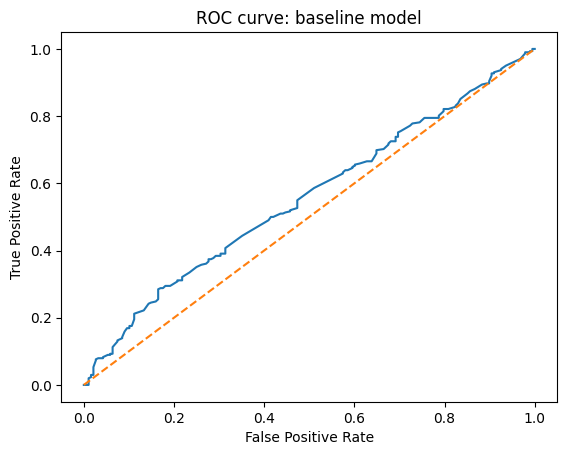

In [19]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Recreate X and y (same as before, to keep this cell self-contained)
X = df_model[['age', 'sex_male', 'side_right']].copy()
X = sm.add_constant(X)
y = df_model['cs_present_bin']

# 2. Refit the same binomial GLM with cluster-robust SEs (for completeness)
glm_model = sm.GLM(y, X, family=sm.families.Binomial())
glm_result = glm_model.fit(
    cov_type='cluster',
    cov_kwds={'groups': df_model['name']}
)

# 3. Get predicted probabilities for cs_present_bin = 1
y_pred_prob = glm_result.predict(X)

# 4. Compute AUC
auc = roc_auc_score(y, y_pred_prob)
print(f"AUC for baseline model (age + sex + side): {auc:.3f}")

# 5. Compute ROC curve and plot
fpr, tpr, thresholds = roc_curve(y, y_pred_prob)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: baseline model')
plt.show()


In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score

# Features and outcome for ML
X_ml = df_model[['age', 'sex_male', 'side_right']].values
y_ml = df_model['cs_present_bin'].values

# Group by patient so both sides of the same person stay in the same fold
groups = df_model['name'].values

gkf = GroupKFold(n_splits=5)

y_true_all = []
y_pred_all = []

print("Random Forest, 5-fold GroupKFold (group = patient):")

for fold, (train_idx, test_idx) in enumerate(gkf.split(X_ml, y_ml, groups), start=1):
    X_train, X_test = X_ml[train_idx], X_ml[test_idx]
    y_train, y_test = y_ml[train_idx], y_ml[test_idx]

    # Random Forest classifier
    rf = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'  # handle slight imbalance
    )

    rf.fit(X_train, y_train)
    y_pred_proba = rf.predict_proba(X_test)[:, 1]

    fold_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"  Fold {fold} AUC: {fold_auc:.3f}")

    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred_proba)

# Overall CV performance
overall_auc = roc_auc_score(y_true_all, y_pred_all)
print(f"\nOverall cross-validated AUC (Random Forest): {overall_auc:.3f}")

# Feature importances from the last fitted model
importances = rf.feature_importances_
for name, imp in zip(['age', 'sex_male', 'side_right'], importances):
    print(f"Feature {name}: importance {imp:.3f}")


Random Forest, 5-fold GroupKFold (group = patient):
  Fold 1 AUC: 0.654
  Fold 2 AUC: 0.413
  Fold 3 AUC: 0.432
  Fold 4 AUC: 0.301
  Fold 5 AUC: 0.473

Overall cross-validated AUC (Random Forest): 0.453
Feature age: importance 0.962
Feature sex_male: importance 0.020
Feature side_right: importance 0.018


In [22]:
import numpy as np
import pandas as pd

# We start from df_model

# 1. Ensure position_desc exists; if not, reconstruct it from position_code
if 'position_desc' not in df_model.columns:
    anatomical_map_no_zero = {
        1: 'PAL CI',
        2: 'PAL LI',
        3: 'PAL CAN',
        4: 'DIS PAL CI',
        5: 'DIS PAL LI',
        6: 'DIS PAL CAN',
        7: 'MES PAL CI',
        8: 'MES PAL LI',
        9: 'MES PAL CAN'
    }
    df_model['position_desc'] = np.where(
        df_model['cs_present_bin'] == 0,
        'ABSENT',
        df_model['position_code'].map(anatomical_map_no_zero).fillna('UNKNOWN')
    )

# 2. Create 'tooth' variable (CI / LI / CAN / ABSENT / UNKNOWN)
def extract_tooth(desc):
    if 'CI' in desc:
        return 'CI'
    elif 'LI' in desc:
        return 'LI'
    elif 'CAN' in desc:
        return 'CAN'
    elif desc == 'ABSENT':
        return 'ABSENT'
    else:
        return 'UNKNOWN'

df_model['tooth'] = df_model['position_desc'].astype(str).apply(extract_tooth)

# 3. Create 'pos_relative' variable (PAL / MES PAL / DIS PAL / ABSENT / UNKNOWN)
def extract_pos(desc):
    if desc == 'ABSENT':
        return 'ABSENT'
    if 'MES PAL' in desc:
        return 'MES PAL'
    elif 'DIS PAL' in desc:
        return 'DIS PAL'
    elif 'PAL' in desc:  # plain PAL CI/LI/CAN (mid)
        return 'PAL'
    else:
        return 'UNKNOWN'

df_model['pos_relative'] = df_model['position_desc'].astype(str).apply(extract_pos)

# 4. Show distributions among sides with a canal
present = df_model[df_model['cs_present_bin'] == 1]

print("Tooth frequencies among sides with canal present:")
print(present['tooth'].value_counts())

print("\nRelative-position frequencies among sides with canal present:")
print(present['pos_relative'].value_counts())

print("\nCross-tab (tooth x pos_relative) among canal-present sides:")
print(pd.crosstab(present['tooth'], present['pos_relative']))


Tooth frequencies among sides with canal present:
tooth
LI         142
CI         112
CAN         46
UNKNOWN      2
Name: count, dtype: int64

Relative-position frequencies among sides with canal present:
pos_relative
PAL        154
DIS PAL     88
MES PAL     58
UNKNOWN      2
Name: count, dtype: int64

Cross-tab (tooth x pos_relative) among canal-present sides:
pos_relative  DIS PAL  MES PAL  PAL  UNKNOWN
tooth                                       
CAN                 8       11   27        0
CI                 47        8   57        0
LI                 33       39   70        0
UNKNOWN             0        0    0        2


In [23]:
import numpy as np
import pandas as pd

# 1. Keep only sides where a canal is present
df_cs = df_model[df_model['cs_present_bin'] == 1].copy()
print("Sides with canal present (before exclusions):", df_cs.shape[0])

# 2. Exclude sides where tooth is UNKNOWN (cannot classify)
unknown_count = (df_cs['tooth'] == 'UNKNOWN').sum()
print("Sides with UNKNOWN tooth label:", unknown_count)

df_cs = df_cs[df_cs['tooth'] != 'UNKNOWN'].copy()
print("Sides with canal present (after removing UNKNOWN tooth):", df_cs.shape[0])

# 3. Define binary outcome: 1 = lateral incisor (LI), 0 = other (CI or CAN)
df_cs['tooth_LI_bin'] = np.where(df_cs['tooth'] == 'LI', 1, 0)

print("\ntooth frequencies in df_cs:")
print(df_cs['tooth'].value_counts())

print("\nBinary outcome tooth_LI_bin (1 = LI, 0 = CI or CAN):")
print(df_cs['tooth_LI_bin'].value_counts())

# 4. Check for missing in key variables for this new task
key_vars_li = ['age', 'sex_male', 'side_right', 'tooth_LI_bin']
print("\nMissing values in key vars (df_cs):")
print(df_cs[key_vars_li].isna().sum())


Sides with canal present (before exclusions): 302
Sides with UNKNOWN tooth label: 2
Sides with canal present (after removing UNKNOWN tooth): 300

tooth frequencies in df_cs:
tooth
LI     142
CI     112
CAN     46
Name: count, dtype: int64

Binary outcome tooth_LI_bin (1 = LI, 0 = CI or CAN):
tooth_LI_bin
0    158
1    142
Name: count, dtype: int64

Missing values in key vars (df_cs):
age             0
sex_male        0
side_right      0
tooth_LI_bin    0
dtype: int64


In [25]:
import pandas as pd

# Find canal-present sides that have UNKNOWN tooth label
unknown_rows = df_model[
    (df_model['cs_present_bin'] == 1) &
    (df_model['tooth'] == 'UNKNOWN')
].copy()

print("Number of UNKNOWN-tooth rows:", unknown_rows.shape[0])
unknown_rows


Number of UNKNOWN-tooth rows: 2


,name,age,sex,canalis_total,cs_present,position_code,side,position_desc,sex_male,cs_present_bin,side_right,side_id,tooth,pos_relative
29,ABDUL RAFIQ,45,M,2,1,0,LEFT,UNKNOWN,1.0,1.0,0.0,30,UNKNOWN,UNKNOWN
66,MUNEERA,35,F,1,1,0,LEFT,UNKNOWN,0.0,1.0,0.0,67,UNKNOWN,UNKNOWN


In [24]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

# 1. Define predictors (X) and outcome (y) for canal-positive sides
X_cs = df_cs[['age', 'sex_male', 'side_right']].copy()
X_cs = sm.add_constant(X_cs)   # intercept
y_cs = df_cs['tooth_LI_bin']

# 2. Fit binomial GLM (logistic) with cluster-robust SEs by patient
glm_li = sm.GLM(y_cs, X_cs, family=sm.families.Binomial())
glm_li_res = glm_li.fit(
    cov_type='cluster',
    cov_kwds={'groups': df_cs['name']}   # cluster = patient
)

print("\n=== Logistic regression (LI vs CI/CAN) with cluster-robust SEs ===")
print(glm_li_res.summary())

# 3. Odds-ratio table
params = glm_li_res.params
conf = glm_li_res.conf_int()
pvals = glm_li_res.pvalues

or_li = pd.DataFrame({
    'OR': np.exp(params),
    'CI_low': np.exp(conf[0]),
    'CI_high': np.exp(conf[1]),
    'p_value': pvals
})

print("\n=== Odds ratios for LI vs CI/CAN (cluster-robust SEs) ===")
print(or_li)



=== Logistic regression (LI vs CI/CAN) with cluster-robust SEs ===
                 Generalized Linear Model Regression Results                  
Dep. Variable:           tooth_LI_bin   No. Observations:                  300
Model:                            GLM   Df Residuals:                      296
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -203.85
Date:                Tue, 02 Dec 2025   Deviance:                       407.70
Time:                        05:27:04   Pearson chi2:                     300.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.02416
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------

In [26]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

# 1. Predictors (X) and outcome (y) for canal-positive sides
X_cs = df_cs[['age', 'sex_male', 'side_right']].copy()
X_cs = sm.add_constant(X_cs)   # intercept
y_cs = df_cs['tooth_LI_bin']

# 2. Binomial GLM (logistic) with cluster-robust SEs by patient
glm_li = sm.GLM(y_cs, X_cs, family=sm.families.Binomial())
glm_li_res = glm_li.fit(
    cov_type='cluster',
    cov_kwds={'groups': df_cs['name']}   # cluster at patient level
)

print("\n=== Logistic regression (LI vs CI/CAN) with cluster-robust SEs ===")
print(glm_li_res.summary())

# 3. Odds-ratio table
params = glm_li_res.params
conf = glm_li_res.conf_int()
pvals = glm_li_res.pvalues

or_li = pd.DataFrame({
    'OR': np.exp(params),
    'CI_low': np.exp(conf[0]),
    'CI_high': np.exp(conf[1]),
    'p_value': pvals
})

print("\n=== Odds ratios for LI vs CI/CAN (cluster-robust SEs) ===")
print(or_li)



=== Logistic regression (LI vs CI/CAN) with cluster-robust SEs ===
                 Generalized Linear Model Regression Results                  
Dep. Variable:           tooth_LI_bin   No. Observations:                  300
Model:                            GLM   Df Residuals:                      296
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -203.85
Date:                Tue, 02 Dec 2025   Deviance:                       407.70
Time:                        05:59:05   Pearson chi2:                     300.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.02416
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------

AUC for LI vs CI/CAN logistic model: 0.589


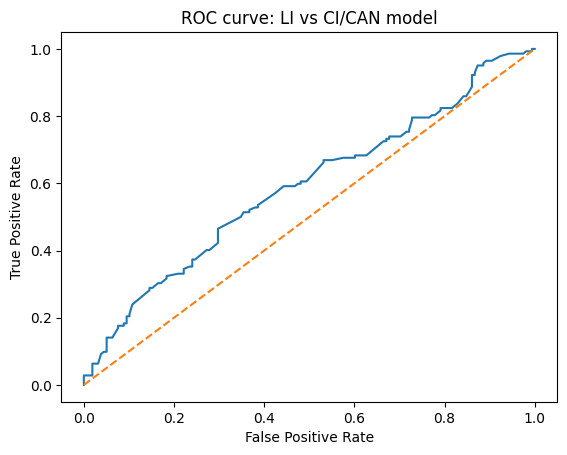

In [27]:
from sklearn.metrics import roc_auc_score, roc_curve
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 1. Recreate X_cs and y_cs (so this cell is self-contained)
X_cs = df_cs[['age', 'sex_male', 'side_right']].copy()
X_cs = sm.add_constant(X_cs)
y_cs = df_cs['tooth_LI_bin']

# 2. Refit the same logistic model with cluster-robust SEs (for completeness)
glm_li = sm.GLM(y_cs, X_cs, family=sm.families.Binomial())
glm_li_res = glm_li.fit(
    cov_type='cluster',
    cov_kwds={'groups': df_cs['name']}
)

# 3. Predicted probabilities for LI (tooth_LI_bin = 1)
y_pred_li = glm_li_res.predict(X_cs)

# 4. AUC
auc_li = roc_auc_score(y_cs, y_pred_li)
print(f"AUC for LI vs CI/CAN logistic model: {auc_li:.3f}")

# 5. ROC curve
fpr, tpr, thresholds = roc_curve(y_cs, y_pred_li)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: LI vs CI/CAN model')
plt.show()


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score

# Features and outcome for LI vs CI/CAN
X_li = df_cs[['age', 'sex_male', 'side_right']].values
y_li = df_cs['tooth_LI_bin'].values

# Group by patient so both sides of a patient stay in same fold
groups_li = df_cs['name'].values

gkf_li = GroupKFold(n_splits=5)

y_true_all = []
y_pred_all = []

print("Random Forest, 5-fold GroupKFold (group = patient) for LI vs CI/CAN:")

for fold, (train_idx, test_idx) in enumerate(gkf_li.split(X_li, y_li, groups_li), start=1):
    X_train, X_test = X_li[train_idx], X_li[test_idx]
    y_train, y_test = y_li[train_idx], y_li[test_idx]

    rf_li = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    )

    rf_li.fit(X_train, y_train)
    y_pred_proba = rf_li.predict_proba(X_test)[:, 1]

    fold_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"  Fold {fold} AUC: {fold_auc:.3f}")

    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred_proba)

overall_auc_li = roc_auc_score(y_true_all, y_pred_all)
print(f"\nOverall cross-validated AUC (Random Forest, LI vs CI/CAN): {overall_auc_li:.3f}")

# Feature importances
importances_li = rf_li.feature_importances_
for name, imp in zip(['age', 'sex_male', 'side_right'], importances_li):
    print(f"Feature {name}: importance {imp:.3f}")


Random Forest, 5-fold GroupKFold (group = patient) for LI vs CI/CAN:
  Fold 1 AUC: 0.571
  Fold 2 AUC: 0.539
  Fold 3 AUC: 0.547
  Fold 4 AUC: 0.528
  Fold 5 AUC: 0.620

Overall cross-validated AUC (Random Forest, LI vs CI/CAN): 0.551
Feature age: importance 0.939
Feature sex_male: importance 0.029
Feature side_right: importance 0.032


In [32]:
import pandas as pd
import numpy as np

# 1. Load original Excel and keep only true patient rows
file_path = "/content/srikant.xlsx"   # change if your filename is different
raw = pd.read_excel(file_path)

df = raw.copy()
df = df[df['NAME'].notna()]
df = df[df['age'].notna()]
print("Patients after basic cleaning:", df.shape[0])  # should be 245

# 2. Fix the '9' mismatch on the right side (LILLY MONTEIRO)
canalis_col       = 'Canalis'
left_present_col  = 'location'
right_present_col = 'Unnamed: 6'
right_pos_col     = 'Unnamed: 10'

left_present  = pd.to_numeric(df[left_present_col],  errors='coerce').fillna(0)
right_present = pd.to_numeric(df[right_present_col], errors='coerce').fillna(0)
canalis_total = pd.to_numeric(df[canalis_col],       errors='coerce').fillna(0)

mask_mismatch = (canalis_total == 0) & (right_present > 0)
df.loc[mask_mismatch, right_pos_col]    = df.loc[mask_mismatch, right_present_col]
df.loc[mask_mismatch, right_present_col] = 0

# 3. Correct mapping of left/right morphometric columns

left_diam_col   = 'diameter NEAR ALVELSR CREST '
right_diam_col  = 'Unnamed: 18'

left_crest_col  = 'cs to alveolar crest'
right_crest_col = 'Unnamed: 22'

left_buccal_col = 'cs to buccal cortical plate'
right_buccal_col= 'Unnamed: 24'

left_nasal_col  = 'csto floor of nasal cavity'
right_nasal_col = 'Unnamed: 26'   # <-- THIS was the missing one

# 4. Build LEFT and RIGHT side tables

left = df[['NAME', 'age', 'sex', canalis_col,
           left_present_col,
           left_diam_col, left_crest_col, left_buccal_col, left_nasal_col]].copy()

right = df[['NAME', 'age', 'sex', canalis_col,
            right_present_col,
            right_diam_col, right_crest_col, right_buccal_col, right_nasal_col]].copy()

left.columns = ['name', 'age', 'sex', 'canalis_total',
                'cs_present',
                'diameter_mm', 'dist_crest_mm', 'dist_buccal_mm', 'dist_nasal_mm']
right.columns = ['name', 'age', 'sex', 'canalis_total',
                 'cs_present',
                 'diameter_mm', 'dist_crest_mm', 'dist_buccal_mm', 'dist_nasal_mm']

left['side'] = 'LEFT'
right['side'] = 'RIGHT'

# 5. Convert to numeric and clean text

for sub in (left, right):
    for col in ['age', 'canalis_total', 'cs_present',
                'diameter_mm', 'dist_crest_mm', 'dist_buccal_mm', 'dist_nasal_mm']:
        sub[col] = pd.to_numeric(sub[col], errors='coerce')
    sub['sex'] = sub['sex'].astype(str).str.strip().str.upper()

# 6. Combine into df_risk and create derived variables

df_risk = pd.concat([left, right], ignore_index=True)

df_risk['sex_male'] = np.where(df_risk['sex'] == 'M', 1,
                               np.where(df_risk['sex'] == 'F', 0, np.nan))

df_risk['side_right'] = np.where(df_risk['side'] == 'RIGHT', 1, 0)
df_risk['cs_present_bin'] = np.where(df_risk['cs_present'] >= 1, 1, 0)

# 7. Define high-risk canals
#    (only meaningful when a canal is present)

df_risk['high_risk'] = 0

mask_high = (df_risk['cs_present_bin'] == 1) & (
    (df_risk['diameter_mm'] >= 1.0) |
    (df_risk['dist_crest_mm'] <= 2.0) |
    (df_risk['dist_buccal_mm'] <= 1.0) |
    (df_risk['dist_nasal_mm'] <= 2.0)
)

df_risk.loc[mask_high, 'high_risk'] = 1

# 8. Basic summaries

print("\nTotal sides in df_risk:", len(df_risk))
print("Sides with canal present:", int(df_risk['cs_present_bin'].sum()))
print("High-risk sides (overall):", int(df_risk['high_risk'].sum()))
print("High-risk among canal-present sides:",
      int(df_risk.loc[df_risk['cs_present_bin'] == 1, 'high_risk'].sum()))

print("\nHigh-risk by sex:")
print(pd.crosstab(df_risk['sex'], df_risk['high_risk']))

print("\nHigh-risk by side:")
print(pd.crosstab(df_risk['side'], df_risk['high_risk']))

# 9. Save for later use if you like
output_path = "/content/cs_morphometric_risk_dataset.xlsx"
df_risk.to_excel(output_path, index=False)
print(f"\nSaved morphometric risk dataset to: {output_path}")


Patients after basic cleaning: 245

Total sides in df_risk: 490
Sides with canal present: 302
High-risk sides (overall): 27
High-risk among canal-present sides: 27

High-risk by sex:
high_risk    0   1
sex               
F          259   9
M          204  18

High-risk by side:
high_risk    0   1
side              
LEFT       218  27
RIGHT      245   0

Saved morphometric risk dataset to: /content/cs_morphometric_risk_dataset.xlsx


In [33]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

# 1. Work only with sides where a canal is present
df_risk_cs = df_risk[df_risk['cs_present_bin'] == 1].copy()
print("Canal-present sides:", df_risk_cs.shape[0])
print("High-risk canals among these:", int(df_risk_cs['high_risk'].sum()))

# Quick check: high-risk by side (you've seen this but we repeat inside this step)
print("\nHigh-risk by side among canal-present sides:")
print(pd.crosstab(df_risk_cs['side'], df_risk_cs['high_risk']))

# 2. Define predictors (age + sex); we avoid side as a covariate here
#    because all high-risk canals are on the left, which leads to quasi-separation.
X_hr = df_risk_cs[['age', 'sex_male']].copy()
X_hr = sm.add_constant(X_hr)   # intercept
y_hr = df_risk_cs['high_risk']

# 3. Fit binomial GLM (logistic) with cluster-robust SEs by patient
glm_hr = sm.GLM(y_hr, X_hr, family=sm.families.Binomial())
glm_hr_res = glm_hr.fit(
    cov_type='cluster',
    cov_kwds={'groups': df_risk_cs['name']}   # cluster at patient level
)

print("\n=== Logistic regression: high-risk vs age + sex (cluster-robust SEs) ===")
print(glm_hr_res.summary())

# 4. Odds-ratio table
params = glm_hr_res.params
conf = glm_hr_res.conf_int()
pvals = glm_hr_res.pvalues

or_hr = pd.DataFrame({
    'OR': np.exp(params),
    'CI_low': np.exp(conf[0]),
    'CI_high': np.exp(conf[1]),
    'p_value': pvals
})

print("\n=== Odds ratios for high-risk canals (cluster-robust SEs) ===")
print(or_hr)


Canal-present sides: 302
High-risk canals among these: 27

High-risk by side among canal-present sides:
high_risk    0   1
side              
LEFT       126  27
RIGHT      149   0

=== Logistic regression: high-risk vs age + sex (cluster-robust SEs) ===
                 Generalized Linear Model Regression Results                  
Dep. Variable:              high_risk   No. Observations:                  302
Model:                            GLM   Df Residuals:                      299
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -88.240
Date:                Tue, 02 Dec 2025   Deviance:                       176.48
Time:                        06:34:17   Pearson chi2:                     301.
No. Iterations:                     6   Pseudo R-squ. (CS):            0.01778
Covariance Type:              clust

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score

# 1. Use only canal-present sides (same subset as logistic model)
df_risk_cs = df_risk[df_risk['cs_present_bin'] == 1].copy()

X_hr_ml = df_risk_cs[['age', 'sex_male']].values   # same predictors as logistic model
y_hr_ml = df_risk_cs['high_risk'].values
groups_hr = df_risk_cs['name'].values              # group by patient

gkf_hr = GroupKFold(n_splits=5)

y_true_all = []
y_pred_all = []

print("Random Forest, 5-fold GroupKFold (group = patient) for HIGH-RISK canal:")

for fold, (train_idx, test_idx) in enumerate(gkf_hr.split(X_hr_ml, y_hr_ml, groups_hr), start=1):
    X_train, X_test = X_hr_ml[train_idx], X_hr_ml[test_idx]
    y_train, y_test = y_hr_ml[train_idx], y_hr_ml[test_idx]

    rf_hr = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'   # handle the 27 / 275 imbalance
    )

    rf_hr.fit(X_train, y_train)
    y_pred_proba = rf_hr.predict_proba(X_test)[:, 1]

    fold_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"  Fold {fold} AUC: {fold_auc:.3f}")

    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred_proba)

overall_auc_hr = roc_auc_score(y_true_all, y_pred_all)
print(f"\nOverall cross-validated AUC (Random Forest, high-risk): {overall_auc_hr:.3f}")

# Feature importances from the last fitted model
importances_hr = rf_hr.feature_importances_
for name, imp in zip(['age', 'sex_male'], importances_hr):
    print(f"Feature {name}: importance {imp:.3f}")


Random Forest, 5-fold GroupKFold (group = patient) for HIGH-RISK canal:
  Fold 1 AUC: 0.826
  Fold 2 AUC: 0.320
  Fold 3 AUC: 0.551
  Fold 4 AUC: 0.574
  Fold 5 AUC: 0.576

Overall cross-validated AUC (Random Forest, high-risk): 0.565
Feature age: importance 0.842
Feature sex_male: importance 0.158


In [35]:
import pandas as pd
from scipy.stats import chi2_contingency

# 1. Work on a copy to be safe
df_chi = df_model.copy()

# Make sure the key variables are as expected
print("Unique sex values:", df_chi['sex'].unique())
print("Unique cs_present_bin values:", df_chi['cs_present_bin'].unique())

# 2. Build 2×2 contingency table: sex (M/F) × canal presence (0/1)
ct = pd.crosstab(df_chi['sex'], df_chi['cs_present_bin'])
ct.columns = ['CS_absent', 'CS_present']
print("\nContingency table: sex × CS presence (per side)")
print(ct)

# 3. Chi-square test of independence
chi2, p, dof, expected = chi2_contingency(ct)

print(f"\nChi-square test results:")
print(f"  χ² = {chi2:.3f}, df = {dof}, p-value = {p:.4f}")
print("\nExpected counts under independence:")
expected_df = pd.DataFrame(expected, index=ct.index, columns=ct.columns)
print(expected_df)


Unique sex values: ['M' 'F']
Unique cs_present_bin values: [1. 0.]

Contingency table: sex × CS presence (per side)
     CS_absent  CS_present
sex                       
F          105         163
M           83         139

Chi-square test results:
  χ² = 0.098, df = 1, p-value = 0.7545

Expected counts under independence:
     CS_absent  CS_present
sex                       
F    102.82449   165.17551
M     85.17551   136.82449


In [36]:
import pandas as pd
from scipy.stats import chi2_contingency

# 1. Restrict to sides with a canal and known tooth
df_tooth = df_model[
    (df_model['cs_present_bin'] == 1) &
    (df_model['tooth'] != 'UNKNOWN')
].copy()

print("Canal-positive sides with known tooth:", df_tooth.shape[0])
print("Tooth levels:", df_tooth['tooth'].value_counts())

# 2. Build contingency table: sex × tooth (CI / LI / CAN)
ct_tooth = pd.crosstab(df_tooth['sex'], df_tooth['tooth'])
print("\nContingency table: sex × tooth (canal-present sides)")
print(ct_tooth)

# 3. Chi-square test
chi2, p, dof, expected = chi2_contingency(ct_tooth)

print(f"\nChi-square test results:")
print(f"  χ² = {chi2:.3f}, df = {dof}, p-value = {p:.4f}")

print("\nExpected counts under independence:")
expected_df = pd.DataFrame(expected, index=ct_tooth.index, columns=ct_tooth.columns)
print(expected_df)


Canal-positive sides with known tooth: 300
Tooth levels: tooth
LI     142
CI     112
CAN     46
Name: count, dtype: int64

Contingency table: sex × tooth (canal-present sides)
tooth  CAN  CI  LI
sex               
F       27  60  75
M       19  52  67

Chi-square test results:
  χ² = 0.497, df = 2, p-value = 0.7801

Expected counts under independence:
tooth    CAN     CI     LI
sex                       
F      24.84  60.48  76.68
M      21.16  51.52  65.32


In [37]:
import pandas as pd
from scipy.stats import chi2_contingency

# 1. Restrict to sides with canal present and known orientation
df_orient = df_model[
    (df_model['cs_present_bin'] == 1) &
    (df_model['pos_relative'] != 'UNKNOWN')
].copy()

print("Canal-present sides with known orientation:", df_orient.shape[0])
print("Orientation levels:", df_orient['pos_relative'].value_counts())

# 2. Run separate χ² tests for LEFT and RIGHT sides
for side in ['LEFT', 'RIGHT']:
    sub = df_orient[df_orient['side'] == side]
    print(f"\n=== {side} side ===")
    print("N (canal-present, known orientation):", sub.shape[0])

    # Contingency table: sex × orientation (PAL / DIS PAL / MES PAL)
    ct_orient = pd.crosstab(sub['sex'], sub['pos_relative'])
    print("\nContingency table: sex × orientation")
    print(ct_orient)

    # Chi-square test of independence
    chi2, p, dof, expected = chi2_contingency(ct_orient)

    print(f"\nChi-square test results ({side}):")
    print(f"  χ² = {chi2:.3f}, df = {dof}, p-value = {p:.4f}")

    print("\nExpected counts under independence:")
    expected_df = pd.DataFrame(expected, index=ct_orient.index, columns=ct_orient.columns)
    print(expected_df)


Canal-present sides with known orientation: 300
Orientation levels: pos_relative
PAL        154
DIS PAL     88
MES PAL     58
Name: count, dtype: int64

=== LEFT side ===
N (canal-present, known orientation): 151

Contingency table: sex × orientation
pos_relative  DIS PAL  MES PAL  PAL
sex                                
F                  27       13   42
M                  21        9   39

Chi-square test results (LEFT):
  χ² = 0.473, df = 2, p-value = 0.7895

Expected counts under independence:
pos_relative    DIS PAL   MES PAL        PAL
sex                                         
F             26.066225  11.94702  43.986755
M             21.933775  10.05298  37.013245

=== RIGHT side ===
N (canal-present, known orientation): 149

Contingency table: sex × orientation
pos_relative  DIS PAL  MES PAL  PAL
sex                                
F                  23       15   42
M                  17       21   31

Chi-square test results (RIGHT):
  χ² = 2.760, df = 2, p-value = 0.2515

In [38]:
import numpy as np
from scipy.stats import ttest_ind

# Work only with canal-positive sides and non-missing morphometry
df_morph = df_risk[(df_risk['cs_present_bin'] == 1)].copy()

print("Canal-positive sides with morphometry:", df_morph.shape[0])

def side_ttests(side_label):
    print(f"\n=== {side_label} side ===")
    sub = df_morph[df_morph['side'] == side_label].copy()
    print("N total:", sub.shape[0])

    # Drop rows with missing sex_male
    sub = sub[sub['sex_male'].notna()].copy()

    males = sub[sub['sex_male'] == 1]
    females = sub[sub['sex_male'] == 0]

    print("N males:", males.shape[0], "N females:", females.shape[0])

    for var in ['diameter_mm', 'dist_crest_mm', 'dist_buccal_mm', 'dist_nasal_mm']:
        m_mean = males[var].mean()
        m_sd   = males[var].std(ddof=1)
        f_mean = females[var].mean()
        f_sd   = females[var].std(ddof=1)

        # t-test with unequal variances (Welch), closest to what SPSS gives if you check Levene
        t_stat, p_val = ttest_ind(males[var].dropna(), females[var].dropna(), equal_var=False)

        print(f"\nVariable: {var}")
        print(f"  Males   mean ± SD: {m_mean:.2f} ± {m_sd:.2f}")
        print(f"  Females mean ± SD: {f_mean:.2f} ± {f_sd:.2f}")
        print(f"  t = {t_stat:.3f}, p = {p_val:.4f}")

# Run for LEFT and RIGHT separately
side_ttests('LEFT')
side_ttests('RIGHT')


Canal-positive sides with morphometry: 302

=== LEFT side ===
N total: 153
N males: 70 N females: 83

Variable: diameter_mm
  Males   mean ± SD: 0.82 ± 0.29
  Females mean ± SD: 0.71 ± 0.23
  t = 2.612, p = 0.0101

Variable: dist_crest_mm
  Males   mean ± SD: 9.63 ± 3.92
  Females mean ± SD: 8.88 ± 3.25
  t = 1.269, p = 0.2065

Variable: dist_buccal_mm
  Males   mean ± SD: 7.78 ± 1.74
  Females mean ± SD: 6.70 ± 1.41
  t = 4.181, p = 0.0001

Variable: dist_nasal_mm
  Males   mean ± SD: 11.73 ± 4.25
  Females mean ± SD: 11.13 ± 3.34
  t = 0.972, p = 0.3331

=== RIGHT side ===
N total: 149
N males: 69 N females: 80

Variable: diameter_mm
  Males   mean ± SD: nan ± nan
  Females mean ± SD: nan ± nan
  t = nan, p = nan

Variable: dist_crest_mm
  Males   mean ± SD: 9.61 ± 3.57
  Females mean ± SD: 8.99 ± 3.08
  t = 1.121, p = 0.2643

Variable: dist_buccal_mm
  Males   mean ± SD: 7.53 ± 1.82
  Females mean ± SD: 6.30 ± 1.24
  t = 4.733, p = 0.0000

Variable: dist_nasal_mm
  Males   mean ± SD

/usr/local/lib/python3.12/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
